# Regression for denoising quasar spectra

In [1]:
import pandas as pd
import numpy as np


In [2]:
import matplotlib.pyplot as plt

%matplotlib inline

In [4]:
df_ts = pd.read_csv('./data/quasar_test.csv')
df_tr = pd.read_csv('./data/quasar_train.csv')

In [7]:
df_tr.head()

,1150.000,1151.000,1152.000,1153.000,1154.000,1155.000,1156.000,1157.000,1158.000,1159.000,...,1590.000,1591.000,1592.000,1593.000,1594.000,1595.000,1596.000,1597.000,1598.000,1599.000
0,0.629,1.910,0.976,2.161,0.964,2.068,1.630,1.716,2.378,-0.540,...,0.532,1.462,0.323,2.515,1.194,0.654,1.056,1.450,0.203,0.382
1,-0.161,1.830,0.609,1.932,0.932,0.857,0.978,1.032,1.793,1.455,...,0.961,1.407,1.296,0.943,1.055,2.265,1.053,1.439,0.767,-0.552
2,-0.085,-1.304,0.691,-0.800,-1.090,1.087,0.734,1.198,1.122,0.742,...,0.447,1.139,0.422,1.248,1.047,0.500,1.514,1.623,1.202,0.924
3,1.283,-0.487,0.660,0.167,-1.217,1.535,2.264,0.220,0.865,-0.723,...,0.714,1.173,1.579,0.477,0.781,0.525,2.466,1.493,1.503,0.698
4,-0.107,0.328,0.681,2.500,0.083,1.876,2.359,1.122,0.584,0.835,...,1.427,2.685,1.152,1.365,0.280,2.246,1.249,1.304,0.578,0.831


In [9]:
df_tr.shape

(200, 450)

In [14]:
cols_tr = df_tr.columns.values.astype(float).astype(int)
cols_ts = df_ts.columns.values.astype(float).astype(int)

In [16]:
assert(cols_tr == cols_ts).all()

In [17]:
df_tr.columns = cols_tr
df_ts.columns = cols_ts

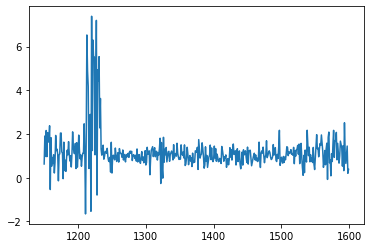

In [18]:
plt.plot(cols_tr, df_tr.loc[0])

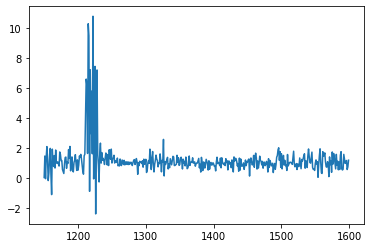

In [20]:
plt.plot(cols_ts, df_ts.loc[0])

## b. (i)

In [51]:
def normal_eq(X, y, W= None):
    if W is None:
        return np.linalg.inv(X.T.dot(X)).dot(X.T).dot(Y)
    else:
        return np.linalg.inv(X.T.dot(W).dot(X)).dot(X.T).dot(W).dot(Y)

In [43]:
x0 = np.ones(df_tr.shape[1])
x1 = cols_tr
Y = df_tr.head(1).values.ravel()
X = np.stack([x0, x1]).T

In [29]:
theta = normal_eq(X, Y)

In [30]:
theta

array([ 2.51339906e+00, -9.81122145e-04])

In [32]:
print(X.shape, Y.shape)

(450, 2) (450,)


In [38]:
predic = X.dot(theta)

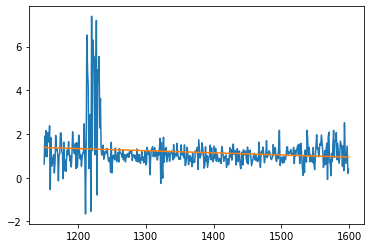

In [39]:
plt.plot(cols_tr, df_tr.loc[0].values)
plt.plot(cols_tr, predic)

## b (ii)

In [46]:
def create_weight_mat(X, x_eval, tau = 5):
    return np.diag(np.exp(- (X[:,1] - x_eval[1]) **2 / (2 * tau ** 2)))

In [48]:
x0 = np.ones(df_tr.shape[1])
x1 = cols_tr
Y = df_tr.head(1).values.ravel()
X = np.stack([x0, x1]).T

In [53]:
res = []
pred_lin = []

for k, x_eval in enumerate(X):
    W = create_weight_mat(X, x_eval)
    theta = normal_eq(X, Y, W)
    pred_lin.append(theta.dot(x_eval))

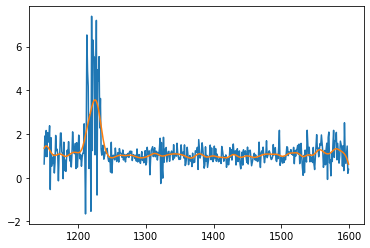

In [56]:
plt.plot(cols_tr, df_tr.loc[0].values)
plt.plot(cols_tr, pred_lin)

## b (iii)

### With tau = 1

In [57]:
pred_lin = []

for k, x_eval in enumerate(X):
    W = create_weight_mat(X, x_eval, 1)
    theta = normal_eq(X, Y, W)
    pred_lin.append(theta.dot(x_eval))

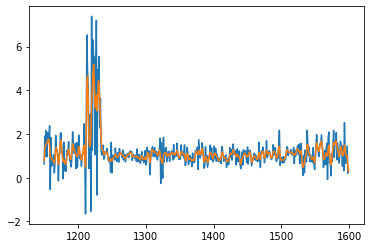

In [58]:
plt.plot(cols_tr, df_tr.loc[0].values)
plt.plot(cols_tr, pred_lin)

### With tau = 10

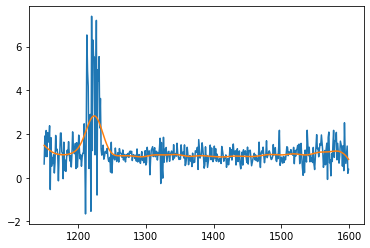

In [59]:
pred_lin = []

for k, x_eval in enumerate(X):
    W = create_weight_mat(X, x_eval, 10)
    theta = normal_eq(X, Y, W)
    pred_lin.append(theta.dot(x_eval))
    
    
plt.plot(cols_tr, df_tr.loc[0].values)
plt.plot(cols_tr, pred_lin)

### With tau = 100

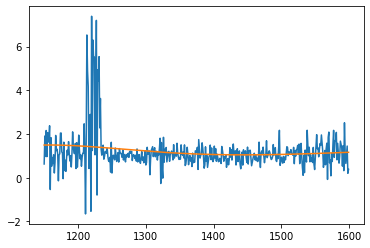

In [64]:
pred_lin = []

for k, x_eval in enumerate(X):
    W = create_weight_mat(X, x_eval, 100)
    theta = normal_eq(X, Y, W)
    pred_lin.append(theta.dot(x_eval))
    
    
plt.plot(cols_tr, df_tr.loc[0].values)
plt.plot(cols_tr, pred_lin)

With increase of tau, the whole prediction seems to flatten out

This could also be seen as loss of sensitivity around changes as tau gets bigger and bigger

## C(i)

In [105]:
def lwr_single(X, y, x, tau):
    """locally weighted regression for a single observation"""
    W = create_weight_mat(X, x, tau=tau)
    theta = normal_eq(X, y, W)
    return theta

In [106]:
def lwr(X, y, xs, tau):
    """lwr for multiple xs"""
    thetas = []
    for x in xs:
        th = lwr_single(X, y, x, tau)
        thetas.append(th)
    return thetas

In [108]:
fs_tv = []
wave_lens = cols_tr
x0 = np.ones(df_tr.shape[1])
x1 = wave_lens
X = np.stack([x0, x1]).T
# used for calculating distances d(f1, f2)
for k, row in df_tr.iterrows():
    print(k, end=',')
    y = row.values
    thetas = lwr(X, y, X, tau=5)
    prd = [_t.dot(_x) for (_t, _x) in zip(thetas, X)]
    fs_tv.append(prd)
df_fs_tv = pd.DataFrame(fs_tv, columns=df_tr.columns)

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,

In [109]:
df_fs_tv.shape

(200, 450)

In [110]:
fs_test = []
x0 = np.ones(df_ts.shape[1])
x1 = wave_lens
X = np.stack([x0, x1]).T
# used for calculating distances d(f1, f2)
for k, row in df_ts.iterrows():
    print(k, end=',')
    y = row.values
    thetas = lwr(X, y, X, tau=5)
    prd = [_t.dot(_x) for (_t, _x) in zip(thetas, X)]
    fs_test.append(prd)
df_fs_test = pd.DataFrame(fs_test, columns=df_ts.columns)

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,

In [ ]:
pass

In [111]:
df_fs_test.shape

(50, 450)

## C (ii)

In [112]:
wl_right= cols_tr[cols_tr>= 1300]
wl_left = cols_tr[cols_tr<1200]

In [113]:
df_fs_tv_r = df_fs_tv[wl_right]
df_fs_tv_l = df_fs_tv[wl_left]

In [114]:
df_fs_tv_r.shape

(200, 300)

In [119]:
def ker(t):
    return np.max(1 - t, 0)

In [122]:
num_neighb = 3 # number of neighbours to consider
errors = []
preds_tv = []
for k, row in df_fs_tv_r.iterrows():
    dists = ((df_fs_tv_r - row) ** 2).sum(axis=1)
    max_d = dists.max()
    neighb_ds = dists.sort_values()[:num_neighb]

    p1 = np.sum([ker(d / max_d) * df_fs_tv_l.loc[idx] for (idx, d) in neighb_ds.iteritems()], axis=0) 
    p2 = np.sum([ker(d / max_d) for (idx, d) in neighb_ds.iteritems()])
    f_left_hat = p1 / p2
    preds_tv.append(f_left_hat)
    error = np.sum((f_left_hat - df_fs_tv_l.loc[k]) ** 2)
    errors.append(error)

C:\Users\ADI\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':
C:\Users\ADI\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


In [123]:
np.mean(errors)

0.0

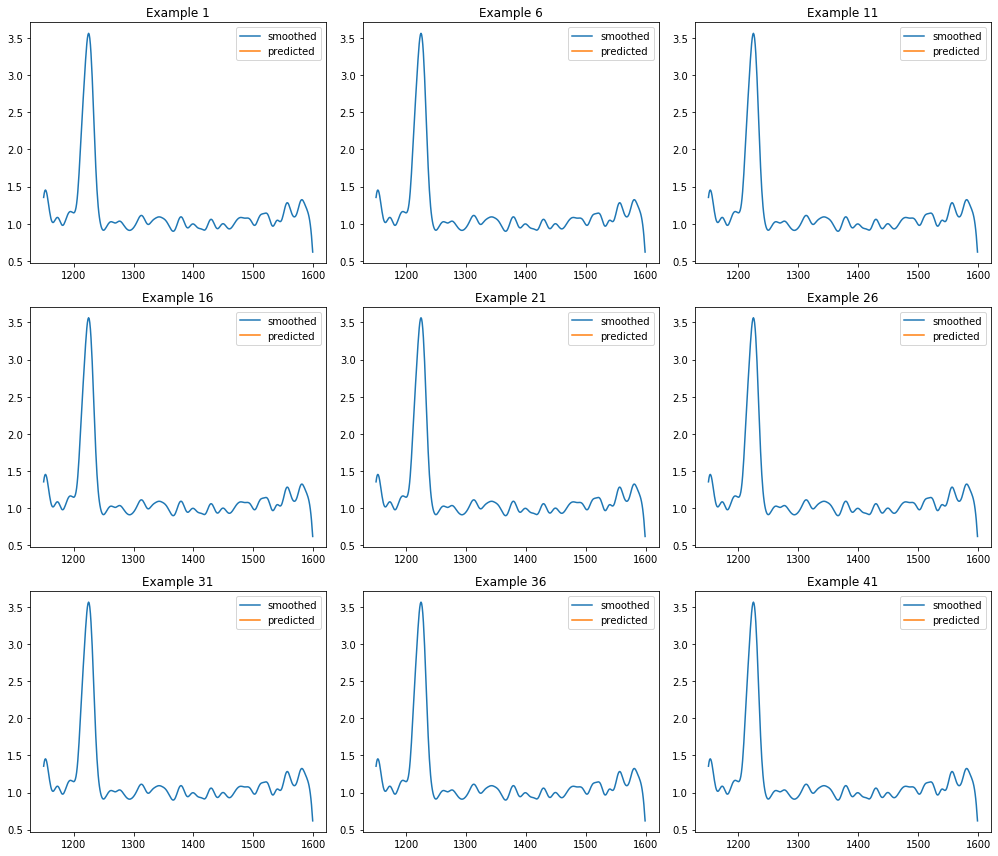

In [124]:
fig, axes = plt.subplots(3, 3, figsize=(14, 12))
axes = axes.ravel()

for k, idx in enumerate([0, 5, 10, 15, 20, 25, 30, 35, 40]):
    ax = axes[k]
    ax.plot(cols_tr, df_fs_tv.loc[idx], label='smoothed')
    ax.plot(wl_left, preds_tv[idx], label='predicted')
    ax.legend()
    ax.set_title('Example {0}'.format(idx + 1))
plt.tight_layout()